# Importing Libraries

In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# Loading Data

In [2]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## About the Dataset
The dataset consists of 2240 datapoints and 29 atrributes. It can be categorized int the following subsets.

i. Customers Info:- ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, Complain.

ii. Products:- (Amount spent on different products in last 2 years)
 MntWines, MntFruits, MntMeatProducts, MnyFishProducts,MntSweetProducts, MntGoldProds

iii. Promotion:- NumDealsPurchased, AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, Response

iv. Place:- NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth


# Data Cleaning

In [3]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

- There are missing values in income.

- Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime.

- There are some categorical features in this data frame; as there are some features in dtype: object. So we  need to encode them into numeric forms later.

For missing values, dropping the rows that have missing values.

In [4]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


- Creating a feature from 'Dt_Customer' that indicates the number of days a customer is registered in the firm's database.
- To keep it simple, taking this value relative to the most recent customer in the record.
- To get the values we must check the newest and oldest recorded dates.

In [7]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format='%d-%m-%Y')
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


- Creating a feature "Customer_For" of the number of days the customers started to shop in the store relative to the last recorded date


In [8]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

- Now exploring the unique values in the categorical features to get a clear idea of the data.

In [9]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


**performing the following steps to engineer some new features:**
- Extracting the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.
- Creating another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.
- Creating another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.
- Creating a feature "Children" to indicate total children in a household that is, kids and teenagers.
- To get further clarity of household, Creating feature indicating "Family_Size"
- Creating a feature "Is_Parent" to indicate parenthood status
- Lastly,  will create three categories in the "Education" by simplifying its value counts.
- Dropping some of the redundant features

In [10]:
#Feature Engineering
#Age of customer today
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

 let's have a look at the data's stats.

In [11]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  Customer_For  \
count   2216.000000   2216.000000  2216.000000  2216.000000  2.216000e+03   
mean       0.064079      0.013538     0.009477     0.150271  3.054423e+16   
std        0.244950      0.115588     0.096907     0.357417  1.749036e+16   
min        0.000000      0.000000     0.000000     0.000000  0.000000e+00   
25%        0.000000      0.000000     0.000000     0.000000  1.555200e+16   
50%        0.000000      0.000000     0.000000     0.000000  3.071520e+16   
75%        0.000000      0.000000     0.000000     0.000000  4.570560e+16   
max        1.000000      1.000000     1.000000     1.000000  6.039360e+16   

               Age        Spent     Children  Family_Size    Is_Parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     52.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      25.000000     5.000000     0.000000     1.000000     0.000000  
25%      44.000000    69.000000     0.000000     2.000000     0.000000  
50%      51.000000   396.500000     1.000000     3.000000     1.000000  
75%      62.000000  1048.000000     1.000000     3.000000     1.000000  
max     128.000000  2525.000000     3.000000     5.000000     1.000000  

[8 rows x 28 columns]

- This shows some discrepancy in mean Income and Age and max Income and age.
- We must take a look at broader view of data. Let's plot some of the selected features.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

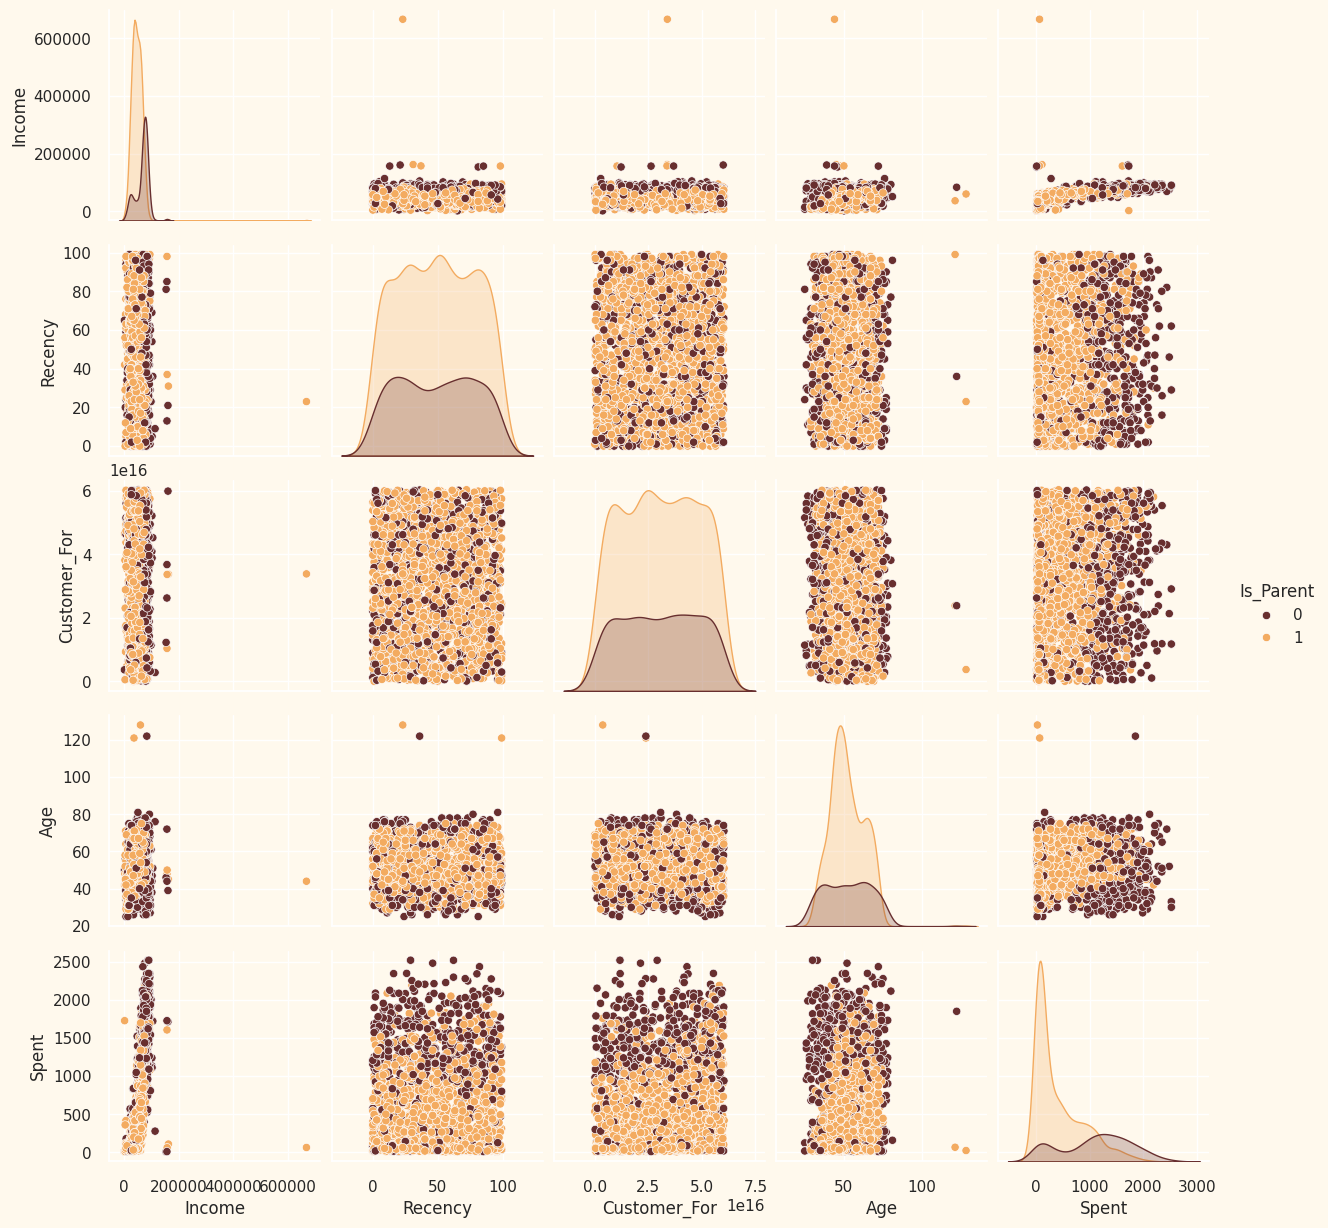

In [12]:
#To plot some selected features
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

- As we can see, there are some outliers in Income and Age features.
- Let's delete the outliers in the data.

In [13]:
#Dropping the outliers by setting a cap on Age and income.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


- Now let's take a look at correlation among the features.

<Axes: >

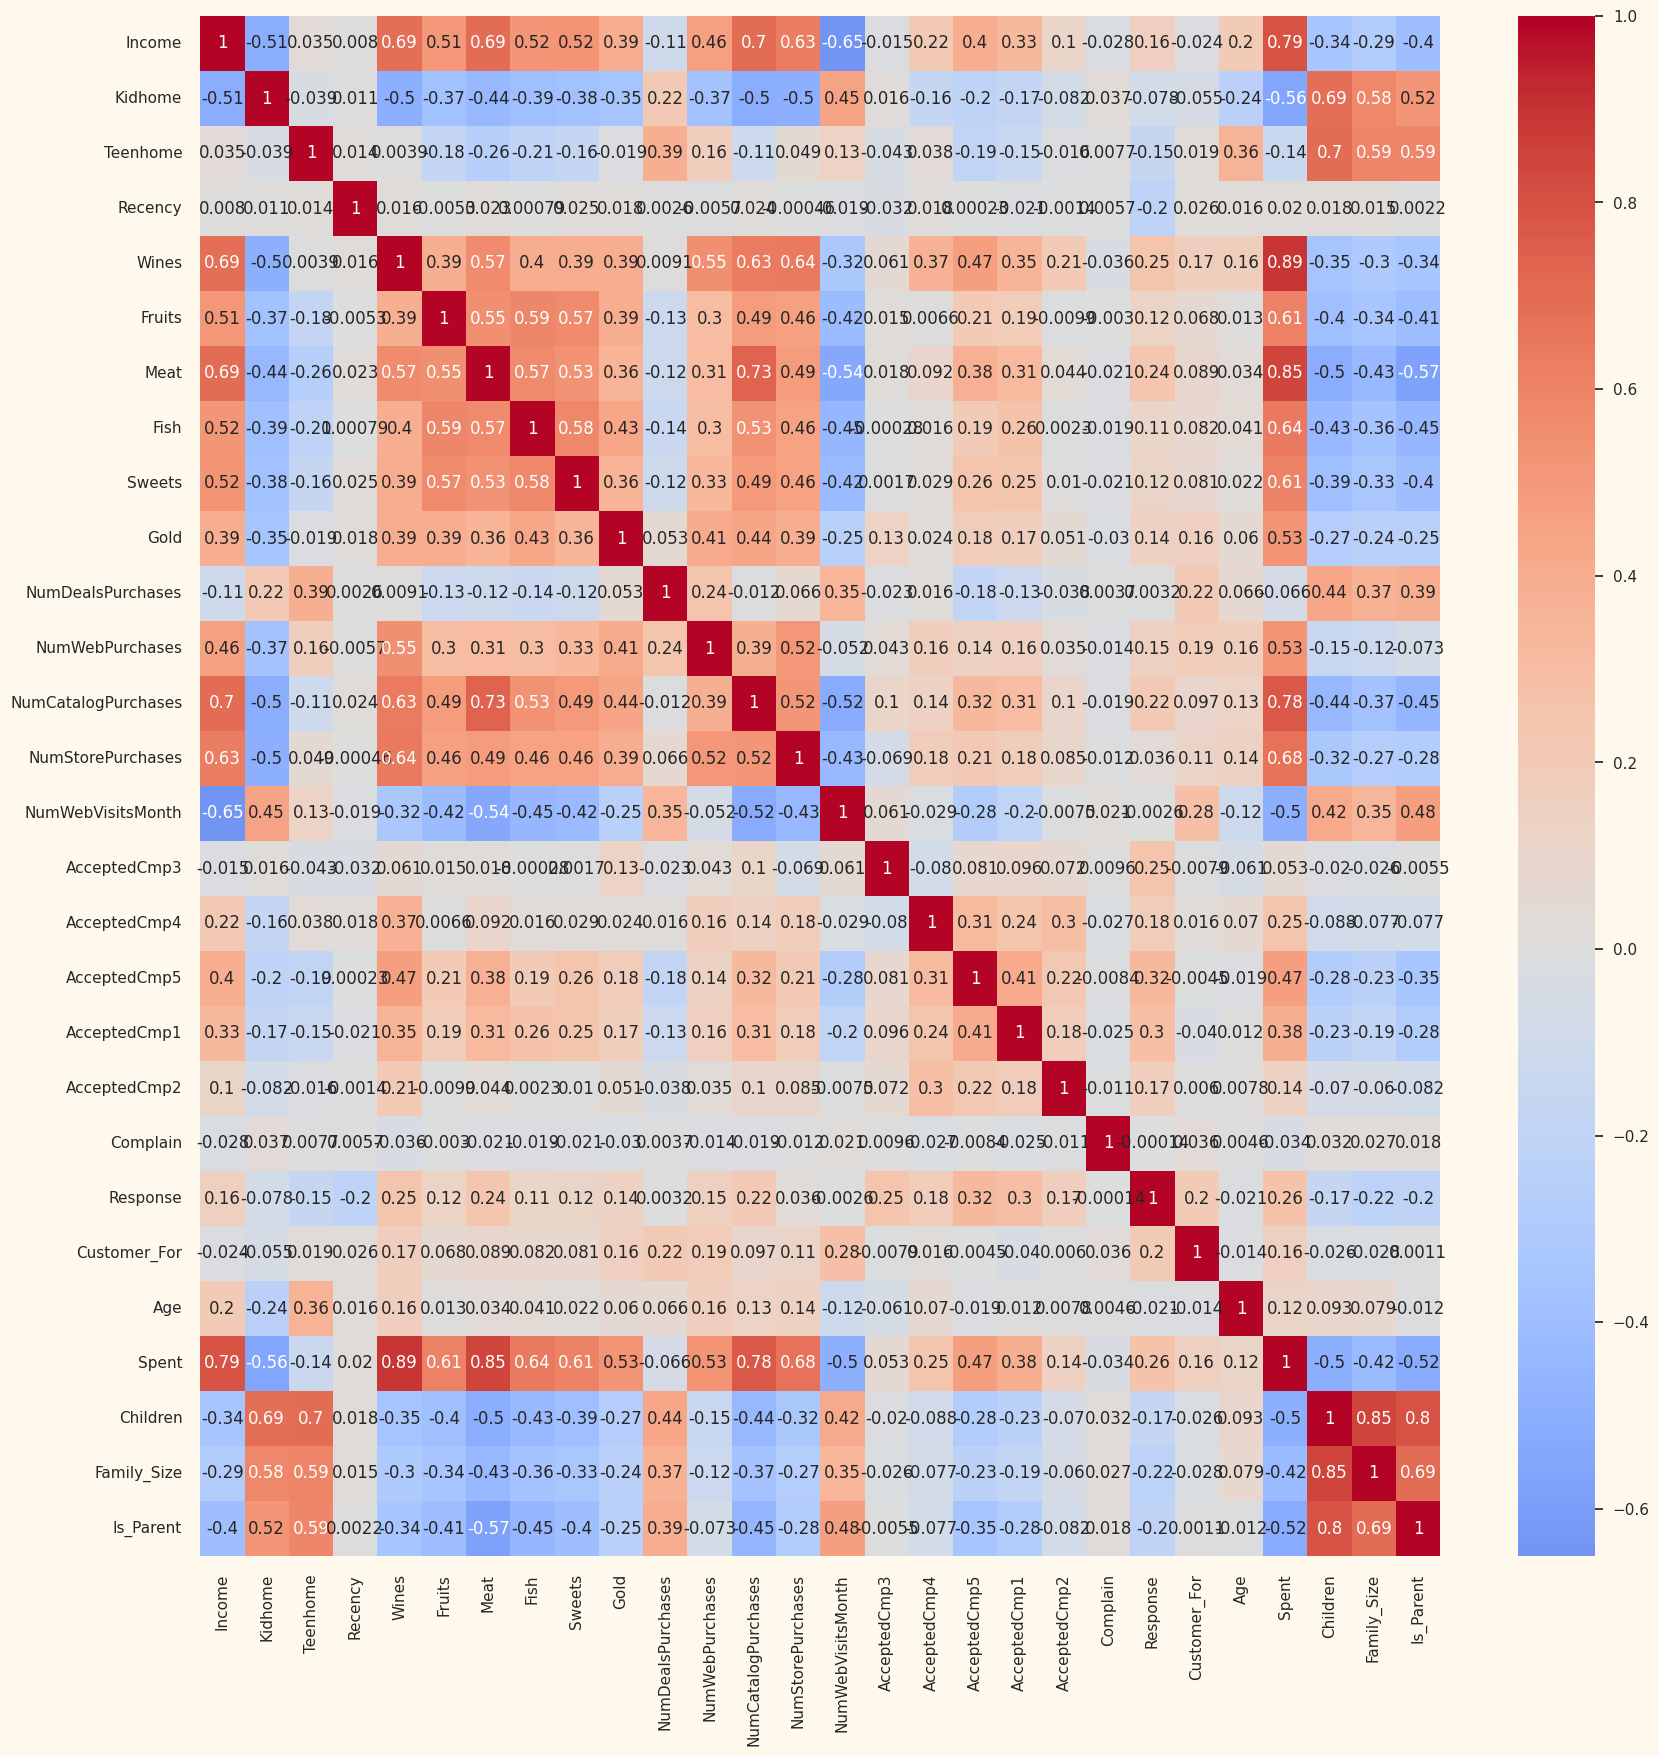

In [16]:
#correlation matrix
numeric_data = data.select_dtypes(include=[float, int])
corrmat = numeric_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', center=0)

Now the data is quite clean and new features have been included.

# Data Preprocessing

## Label encoding the categorical variables

In [17]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [18]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")


All features are now numerical


## Scaling the features using standard scaler

In [19]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


## Creating a subset dataframe for dimentionality reduction

In [20]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish    Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0  1.690293  2.453472  1.483713  ...             2.503607          -0.555814   
1 -0.718230 -0.651004 -0.634019  ...            -0.571340          -1.171160   
2 -0.178542  1.339513 -0.147184  ...            -0.229679           1.290224   
3 -0.655787 -0.504911 -0.585335  ...            -0.913000          -0.555814   
4 -0.218684  0.152508 -0.001133  ...             0.111982           0.059532   

   NumWebVisitsMonth  Customer_For       Age     Spent  Living_With  Children  \
0           0.692181      1.527721  1.018352  1.676245    -1.349603 -1.264598   
1          -0.132545     -1.189011  1.274785 -0.963297    -1.349603  1.404572   
2          -0.544908     -0.206048  0.334530  0.280110     0.740959 -1.264598   
3           0.279818     -1.060584 -1.289547 -0.920135     0.740959  0.069987   
4          -0.132545     -0.951915 -1.033114 -0.307562     0.740959  0.069987   

   Family_Size  Is_Parent  
0    -1.758359  -1.581139  
1     0.449070   0.632456  
2    -0.654644  -1.581139  
3     0.449070   0.632456  
4     0.449070   0.632456  

[5 rows x 23 columns]

# Dimentionality Reduction

- The higher the number of features, the harder it is to work with it.
- Many of these features are correlated, and hence redundant.
- So we will be performing dimensionality reduction on the selected features before putting them through a classifier.

## Dimentionality Reduction with PCA

In [21]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  4.497106e-17  2.878602 -5.978123 -2.539470 -0.781595  2.386380   
col2  2212.0 -1.927331e-17  1.709469 -4.194757 -1.323932 -0.173716  1.234923   
col3  2212.0  2.650080e-17  1.231685 -3.625184 -0.853556 -0.051292  0.863841   

           max  
col1  7.452915  
col2  6.168185  
col3  6.746845

## Plotting the reduced dataframe

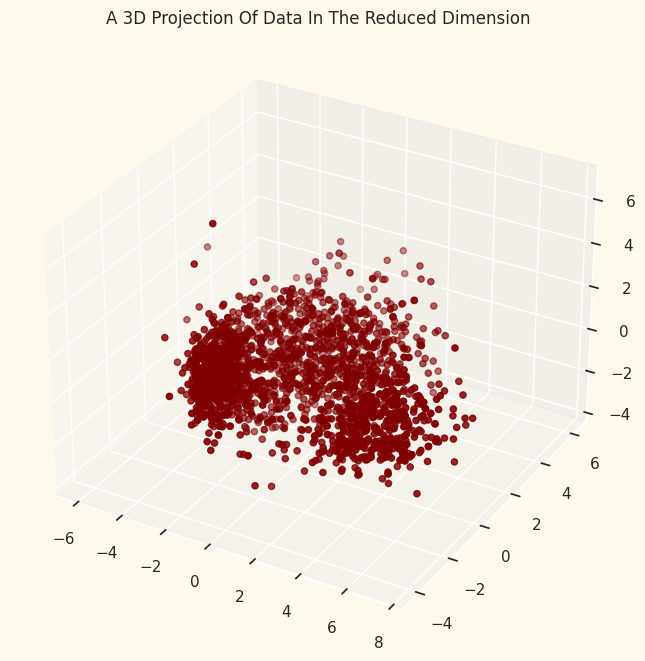

In [22]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering

- Now that we have reduced the attributes to three dimentions, we will be perfoming Agglomerative clustering.

## Elbow method to determine the number of clusters to be formed

Elbow Method to determine the number of clusters to be formed:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

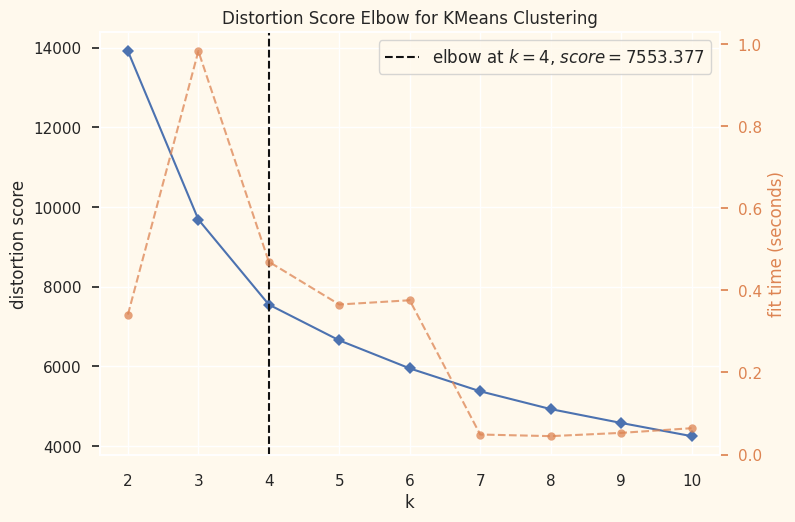

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

## Clustering via Agglomerative clustering

In [24]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

## Examining the clusters via Scatter Plot

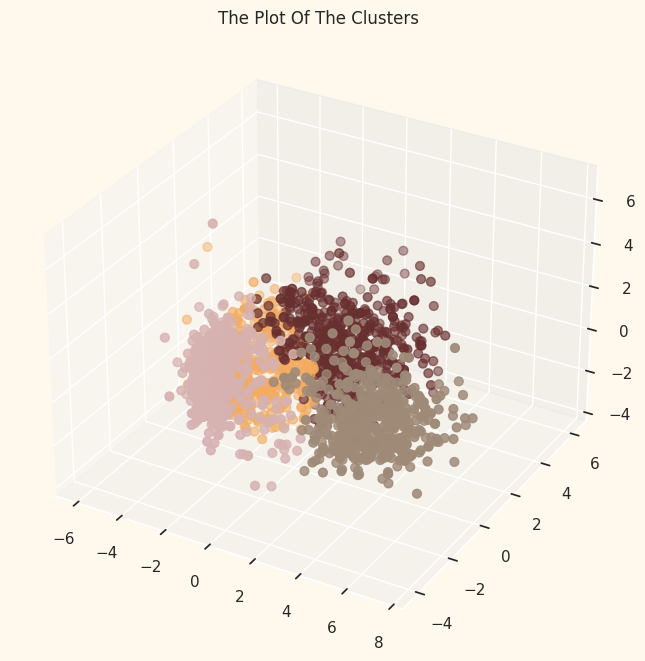

In [25]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# Evaluating Models

- As this is unsupervised clustering, we don't have a tagged feature to evaluate or score our model.
- Let's study the patterns in the clusters formed and determine the nature of clusters' patterns.
- Let's have a look at data in light of clusters via EDA

Firstly, let's take a look at group distribution of clustering

<ipython-input-26-2f63248a592e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)


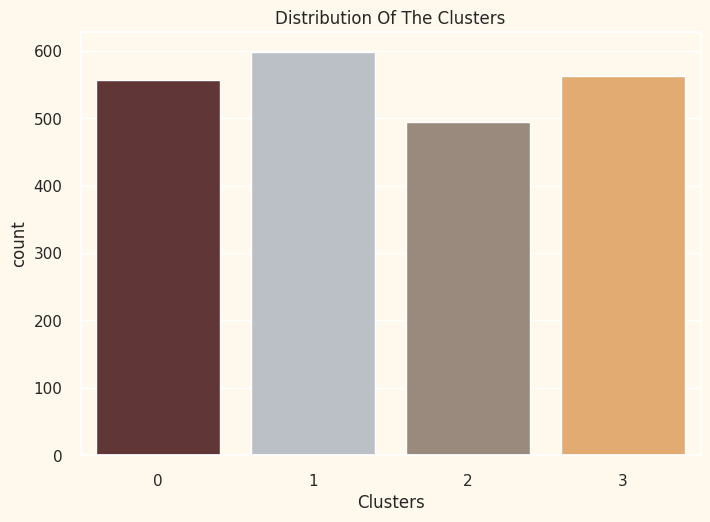

In [26]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

The clusters seem to be evenly spread out.

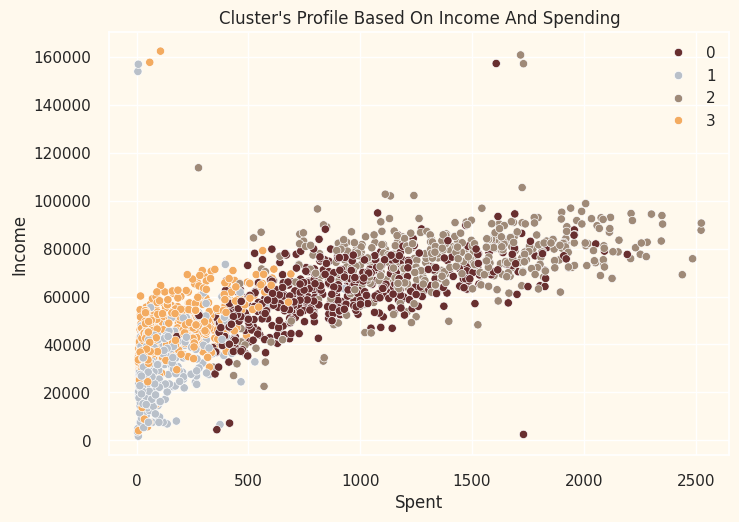

In [27]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Income vs spending plot shows the clusters pattern**

- group 0: high spending & average income
- group 1: low spending & low income
- group 2: high spending & high income
- group 3: high spending & low income

Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 71.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-28-b5a4c0fdc6d1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
/usr/local/lib/python3.10/dist-packages/seaborn/ca

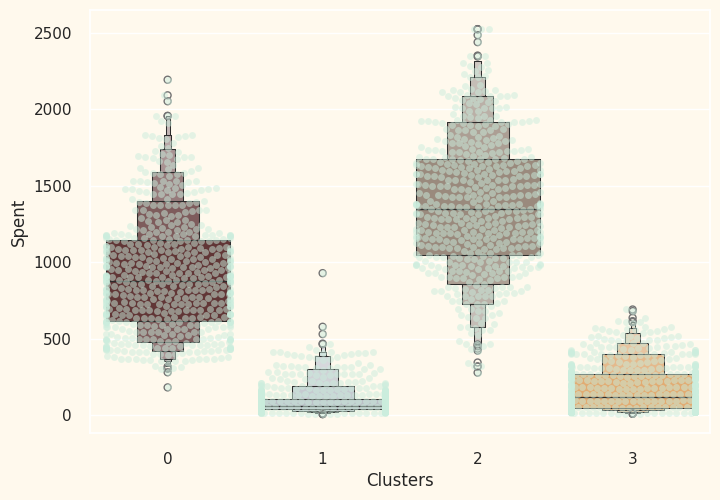

In [28]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

From the above plot, it can be clearly seen that cluster 2 is our biggest set of customers closely followed by cluster 0. We can explore what each cluster is spending on for the targeted marketing strategies.

Now let's next explore how did the campaigns do in the past.

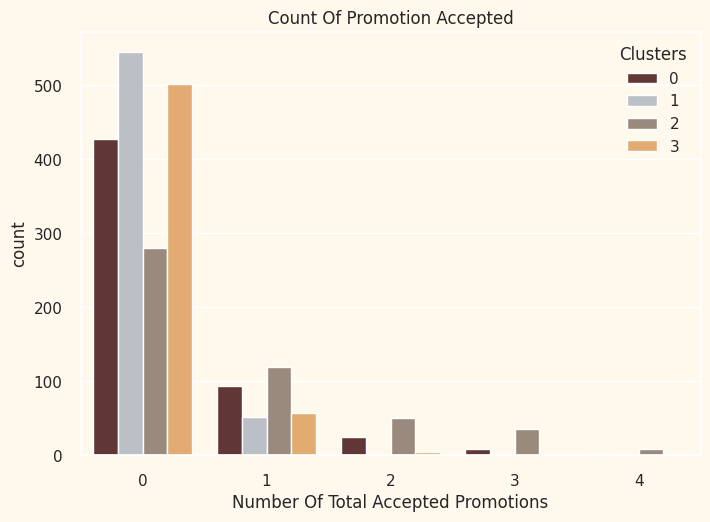

In [29]:
#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

The campaigns haven't had a strong response so far, with only a few participants overall. Additionally, no one has participated in all five campaigns. It seems we need better-targeted and more well-planned campaigns to boost sales.

<ipython-input-30-0ef84d1c8fe9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)


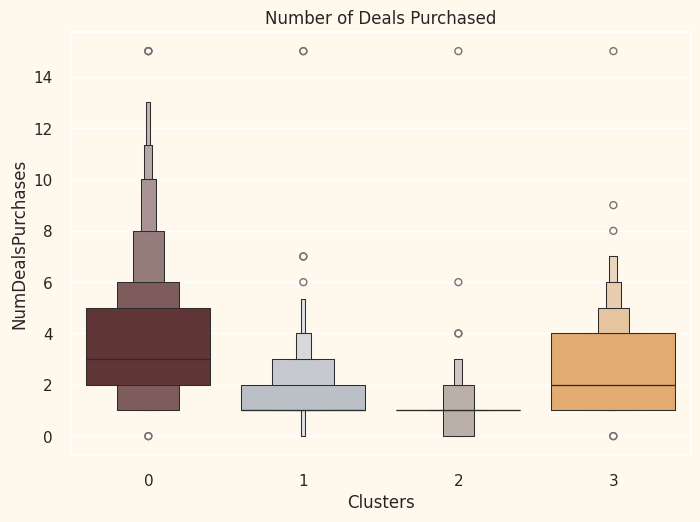

In [30]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike the campaigns, the deals offered performed well. They were most successful with cluster 0 and cluster 3. However, our top customers in cluster 1 didn't show much interest in the deals, and nothing seemed to overwhelmingly attract cluster 2.

# Profiling

Now that we have formed the clusters and analyzed their purchasing habits, let's identify the individuals within these clusters. We'll profile each cluster to determine who our star customers are and who needs more attention from the retail store's marketing team.

To make this determination, I'll plot certain customer features that reflect their personal traits alongside the clusters they belong to. Based on the results, I'll draw conclusions about which customers stand out as stars and which ones might require more attention from the retail store's marketing team.

<Figure size 800x550 with 0 Axes>

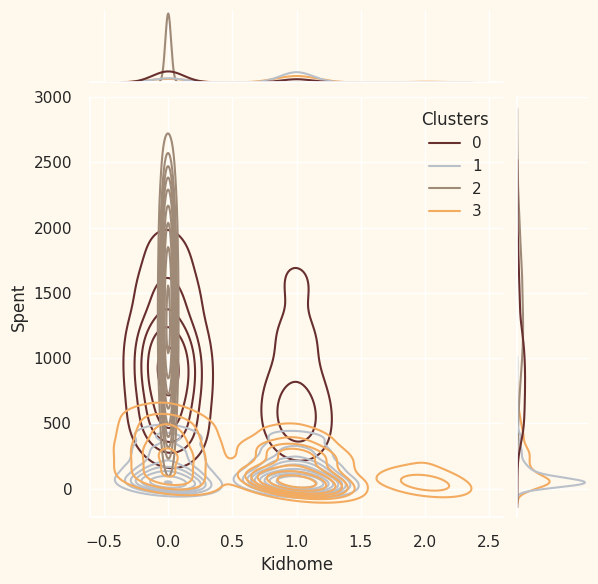

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

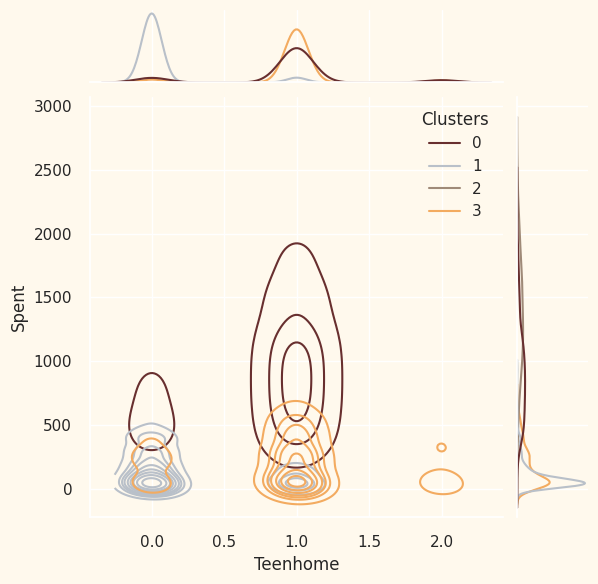

<Figure size 800x550 with 0 Axes>

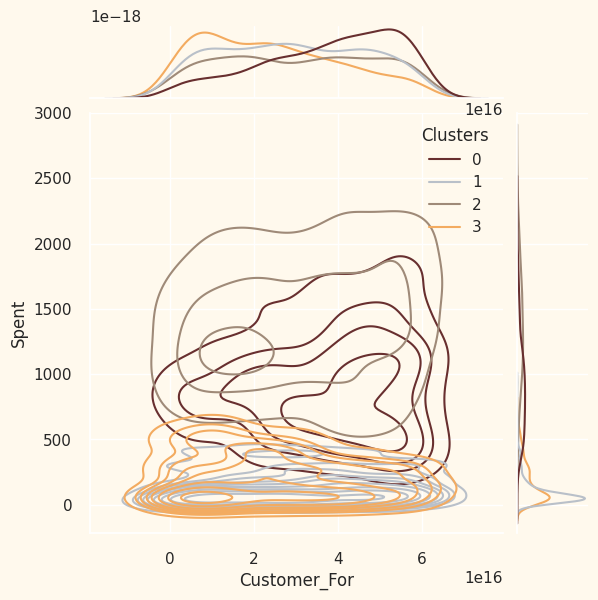

<Figure size 800x550 with 0 Axes>

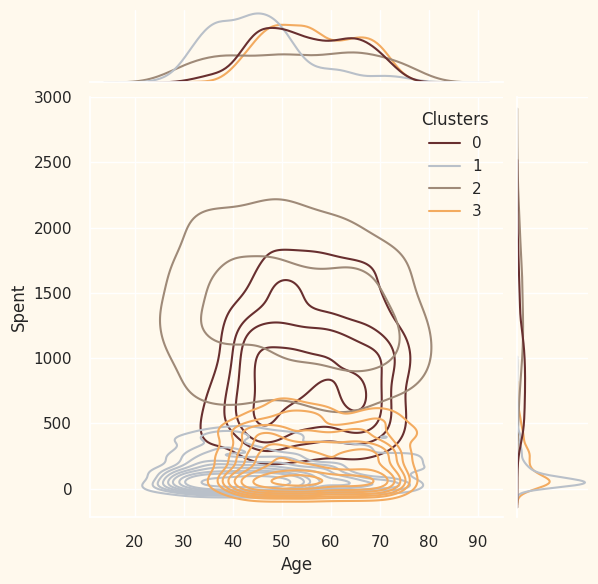

<Figure size 800x550 with 0 Axes>

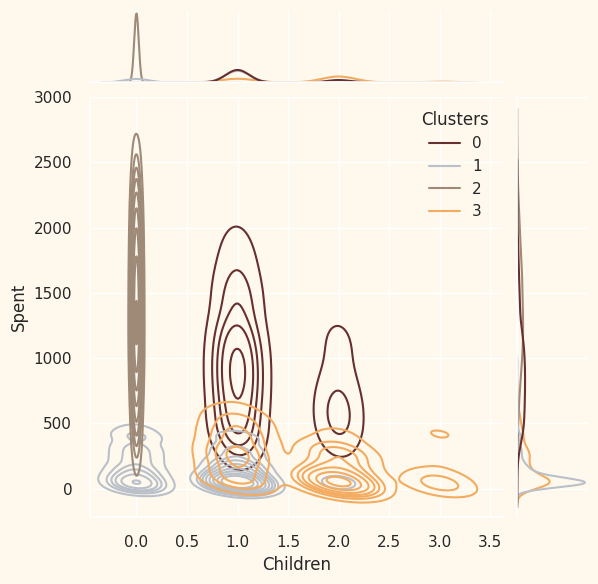

<Figure size 800x550 with 0 Axes>

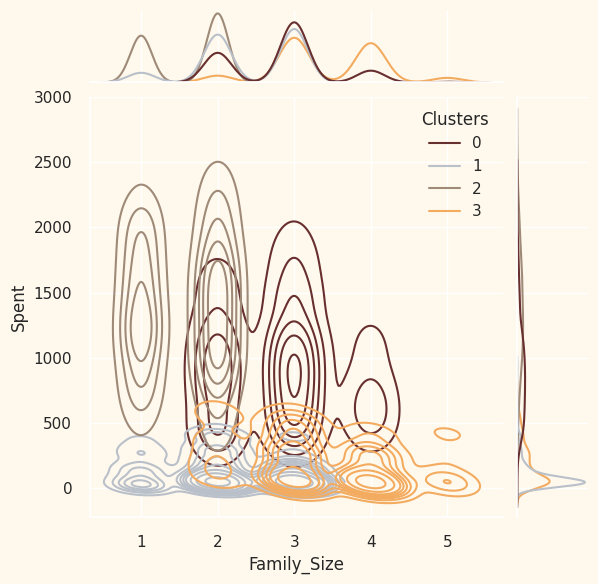

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

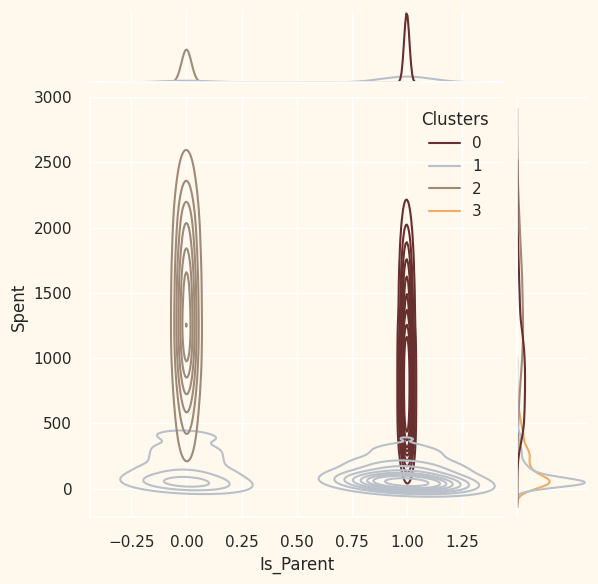

<Figure size 800x550 with 0 Axes>

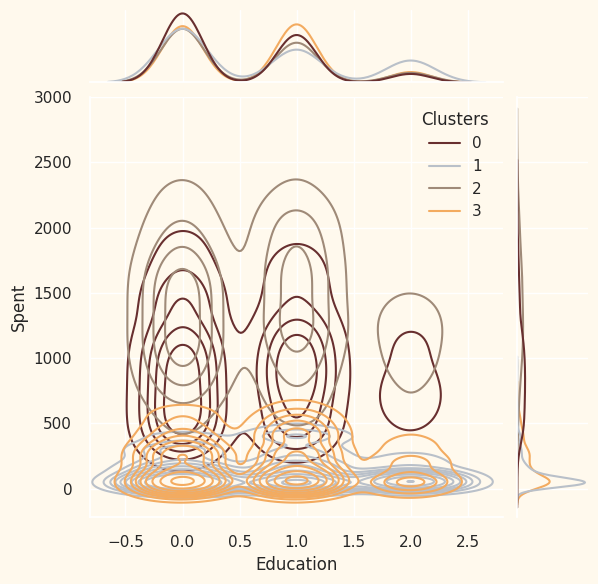

<Figure size 800x550 with 0 Axes>

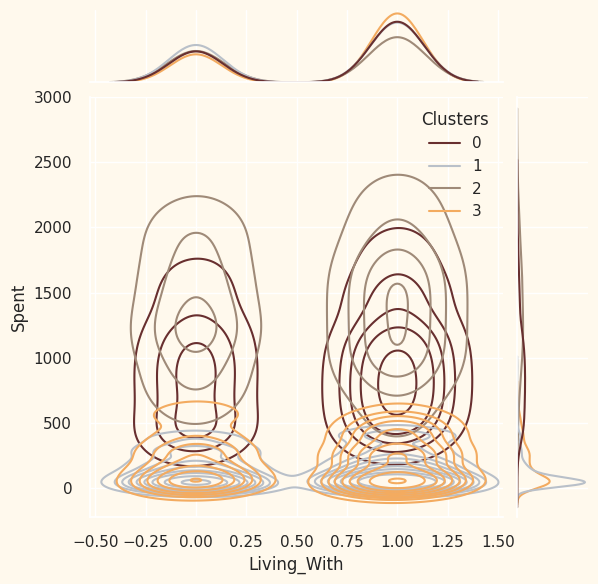

In [31]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

About Cluster Number 0
  - definitely a parent
  - members in family --> max 4, min2
  - single parents are subset of this gruop
  - most of them have teenager at home
  - relatively older

About Cluster Number 1
 - Majority are parents
 - members in family --> max 3
 - majorly have 1 kid
 - relatively younger

About Cluster Number 2
 - definitely not parent
 - members in family --> max 2
 - slight majority of couples over single people
 - span all ages
 - high income group

About Cluster Number 3
 - definitely a parent
 - members in family --> max 5, min 2
 - majority have teenager at home
 - relatively older
 - lower income group

# Conclusion

In this project, I utilized unsupervised clustering techniques, beginning with dimensionality reduction and subsequently employing agglomerative clustering. The result was the identification of four distinct clusters, which I then utilized to profile customers based on their family structures and income/spending habits. This approach can provide valuable insights for devising more effective marketing strategies.